In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [3]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [4]:
plt.rc('font', family='NanumBarunGothic') #set font
plt.rc('axes', unicode_minus=False)

# Load data

In [7]:
df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/DropColsData.csv') #상관관계 높은 열 제거한 데이터
print(df.shape)
df.head()

(129664, 14)


,지역,시간,발전량,일자,기온,풍속,풍향,습도,해면기압,일사,전운량,시정,PM10,월
0,전남 목포시,0,0.0,2013-01-01,-2.0,4.1,160.0,93.0,1021.4,NaN,3.0,2000.0,135.0,1
1,전남 목포시,1,0.0,2013-01-01,-2.2,3.7,160.0,95.0,1021.3,NaN,NaN,NaN,44.0,1
2,전남 목포시,2,0.0,2013-01-01,-2.4,3.6,160.0,95.0,1021.2,NaN,NaN,NaN,34.0,1
3,전남 목포시,3,0.0,2013-01-01,-2.7,3.6,160.0,95.0,1020.8,NaN,7.0,1800.0,41.0,1
4,전남 목포시,4,0.0,2013-01-01,-2.9,4.0,160.0,94.0,1020.0,NaN,7.0,1800.0,41.0,1


In [9]:
area_name = ['Gn', 'Jj', 'Mp' ] 
for idx, area in enumerate(['강원 강릉시','경남 진주시', '전남 목포시']): #지역별로 데이터 분리
  name = area_name[idx]
  data = df[df['지역'] == area]
  data.reset_index(drop=True, inplace=True)
  globals()[f'{name}_df'] = data
print(f'전체데이터: {df.shape},\n목포시 : {Mp_df.shape},\n강릉시 : {Gn_df.shape},\n진주시 : {Jj_df.shape}')

전체데이터: (129664, 14),
목포시 : (61343, 14),
강릉시 : (35063, 14),
진주시 : (33258, 14)


In [10]:
df.columns

Index(['지역', '시간', '발전량', '일자', '기온', '풍속', '풍향', '습도', '해면기압', '일사', '전운량',
       '시정', 'PM10', '월'],
      dtype='object')

In [11]:
def NullPlot(data, area_name, plt, ax):
  cols = [x for x in data.columns if x not in ['지역','일자','시간','월']]
  null_list = data[cols].isnull().sum()
  
  pal = sns.color_palette("Blues", len(cols))
  rank = null_list.argsort().argsort() # 널이 적은 순서대로 순위
  ax.set_title(f'{area_name} of variable', fontsize=20)
  ax.set_xticks(range(1, len(cols)+1))
  ax.set_xticklabels(cols)
  ax.set_xlabel('variables', fontsize=15)
  ax.set_ylabel('Null', fontsize=15)
  ax.set_ylim(0,62000)

  bar = ax.bar(range(1,len(cols)+1), null_list.values, color=np.array(pal)[rank])
  for b in bar:
    x = b.get_x() + b.get_width()/2.0
    y = b.get_height()
    ax.text(x, y, y, ha='center', va='bottom', fontsize=13)

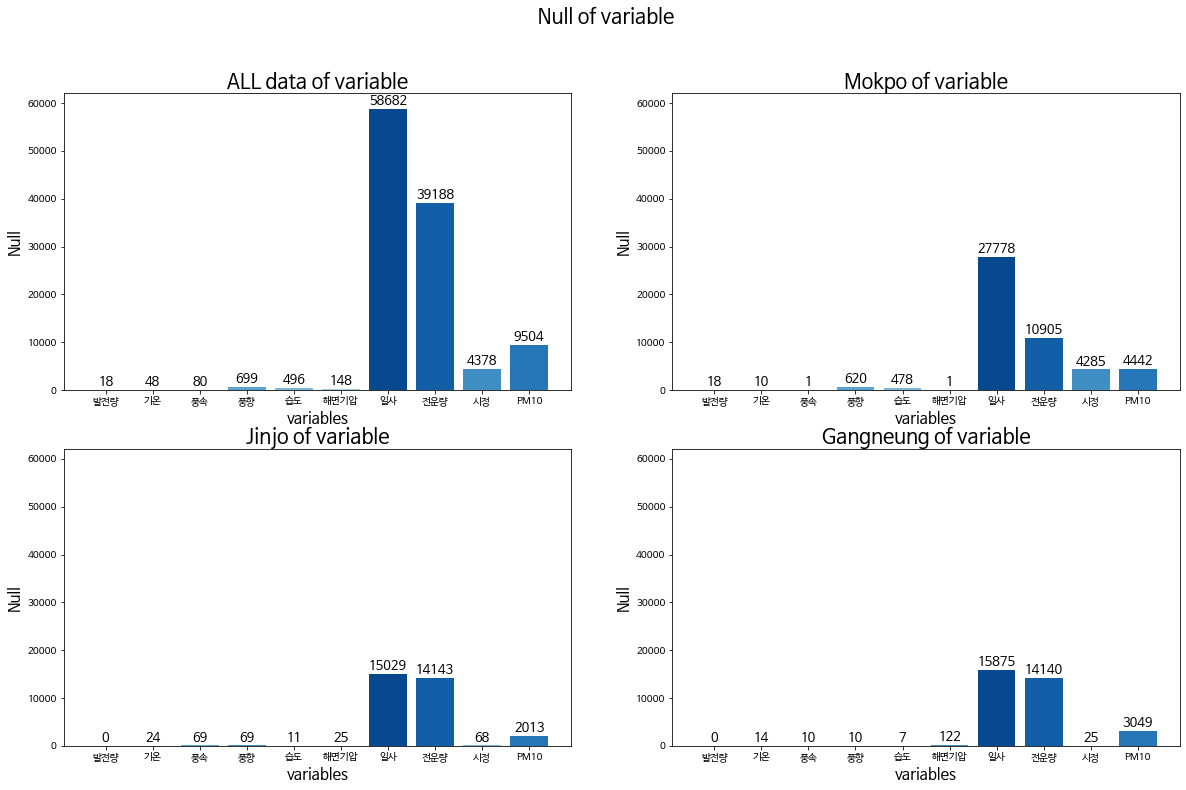

In [12]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20,12), nrows=2, ncols=2)
plt.suptitle(f' Null of variable', fontsize=20)
NullPlot(df, 'ALL data', plt , ax1)
NullPlot(Mp_df, 'Mokpo', plt , ax2)
NullPlot(Jj_df, 'Jinjo', plt , ax3)
NullPlot(Gn_df, 'Gangneung', plt , ax4)
plt.show()

## Distribution of variables

In [ ]:
def scatter(df, target, cols, name):
  plt.figure(figsize=(20,15))

  for idx, col in enumerate(cols):
    ax = plt.subplot(3, 4, idx+1)
    sns.regplot(x = df[target], y = df[col] , data = df, scatter_kws = {'color':'b', 's':6}, line_kws = {'color':'r'})
    ax.set_title(f'{target} ~ {col}', fontsize = 12)
    ax.set_xlabel(f'{target}', fontsize = 8)
    ax.set_ylabel(f'{col}') 
  
  plt.suptitle(f'{name} Scatter Diagram', fontsize = 20, position=(0.5,0.92)) 
  plt.show()

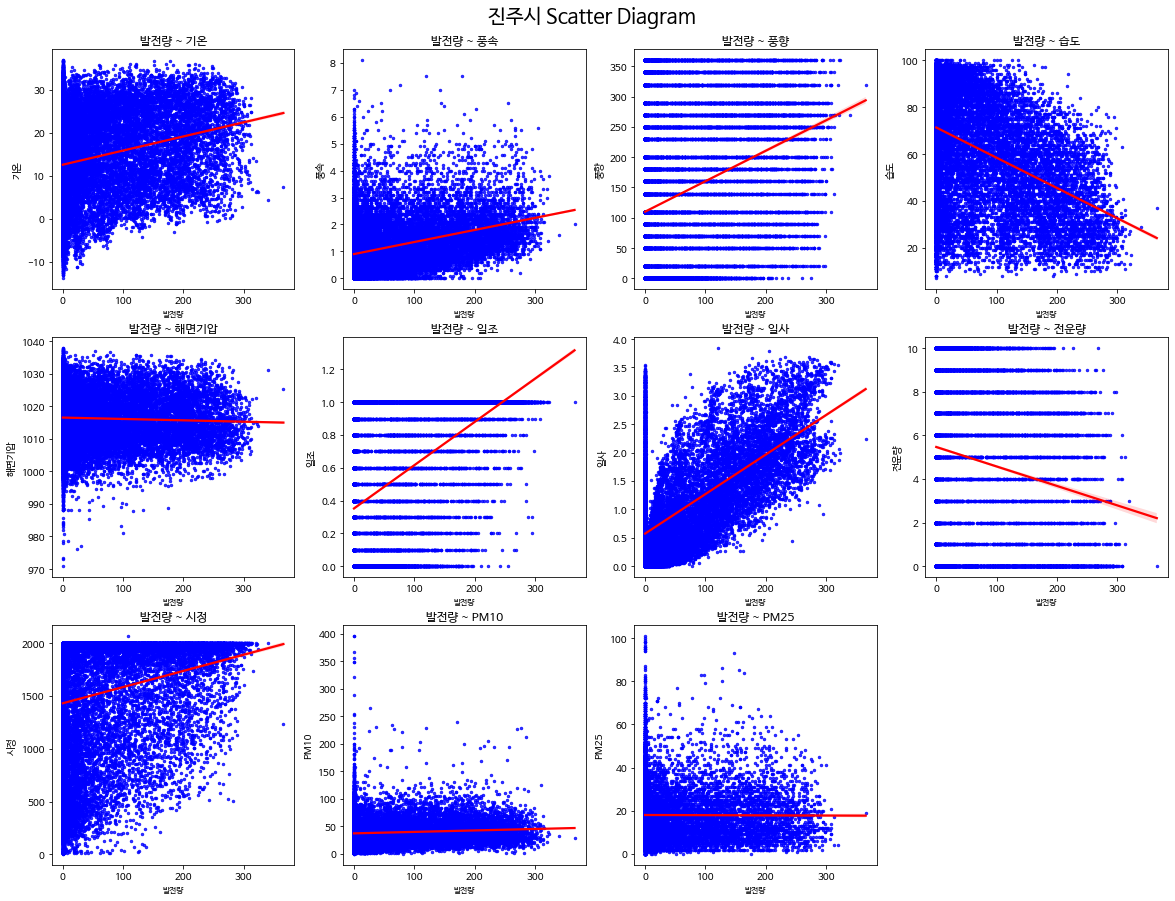

In [ ]:
col_list = [x for x in df.columns if x not in ['지역', '일자', '시간', '월','발전량']]
scatter(Jj_df, '발전량', col_list, "진주시")

In [ ]:
def day_plot(df, cols, name): #2017-2020년도의 모든 시간 데이터의 평균 분포
  plt.figure(figsize=(23,18))
  plt.suptitle(f'{name} distribution of the day', fontsize=25, position=(0.5,0.92))
  for idx, col in enumerate(cols):
    ax = plt.subplot(4, 4, idx+1)
    data = pd.DataFrame()
    for h in range(0,24):
      t_mean = df[df['시간'] == h][col].mean()
      mean_df = pd.DataFrame([[h, t_mean]],columns = ['시간', '평균'])
      data = pd.concat([data, mean_df])
    plt.plot(range(len(data)), data['평균'])
    ax.set_title(f'{col}', fontsize=15)
    # ax.set_xlabel('시간')
    ax.set_xticks(range(len(data)))

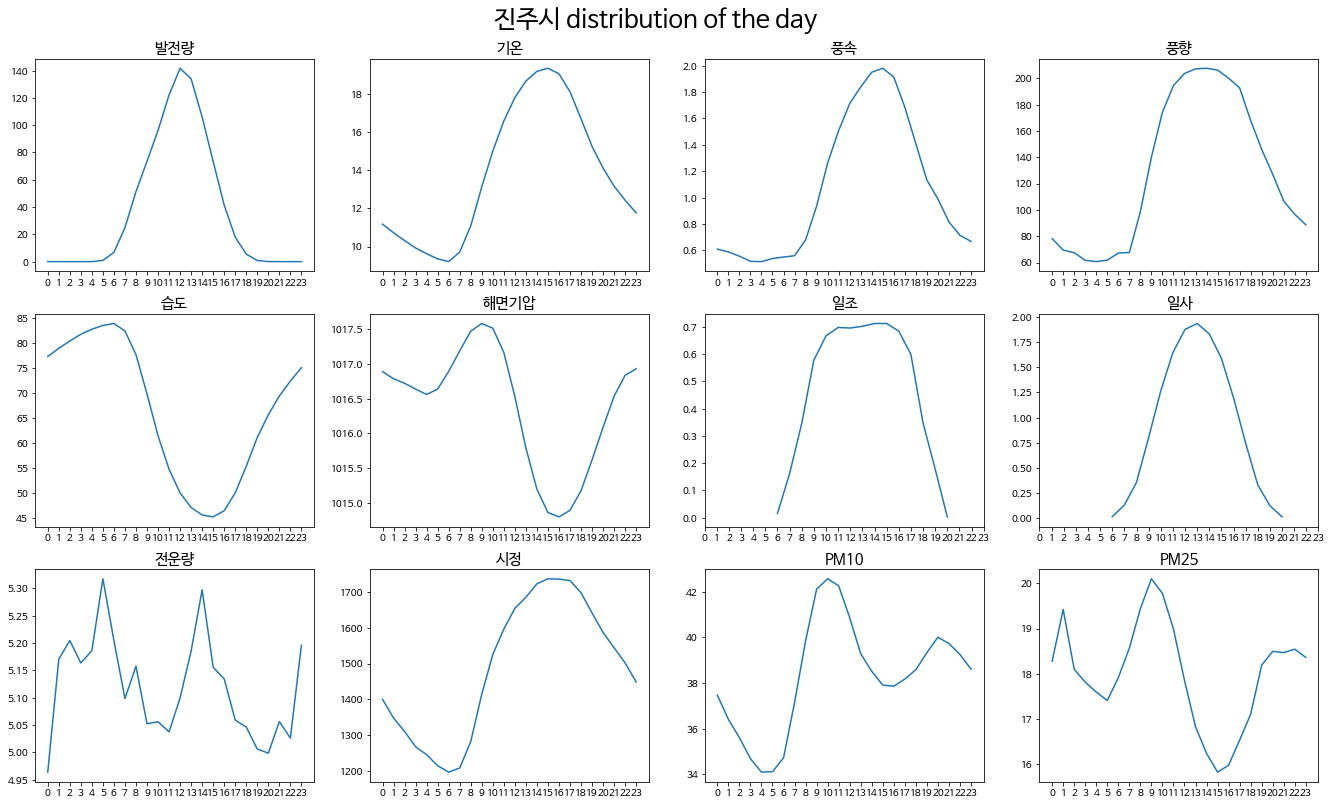

In [ ]:
col_list = [x for x in df.columns if x not in ['지역', '일자', '시간', '월']]
day_plot(Jj_df, col_list, '진주시')

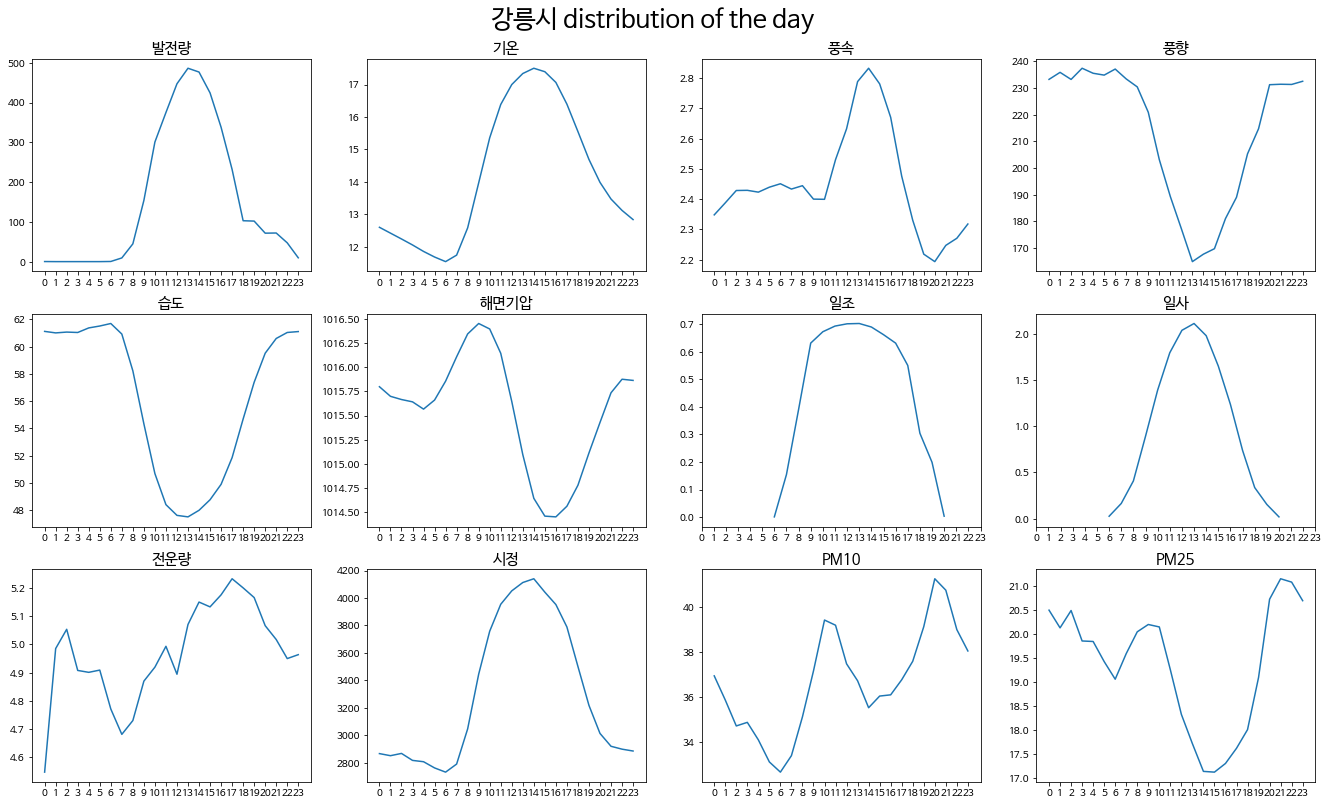

In [ ]:
day_plot(Gn_df, col_list, '강릉시')

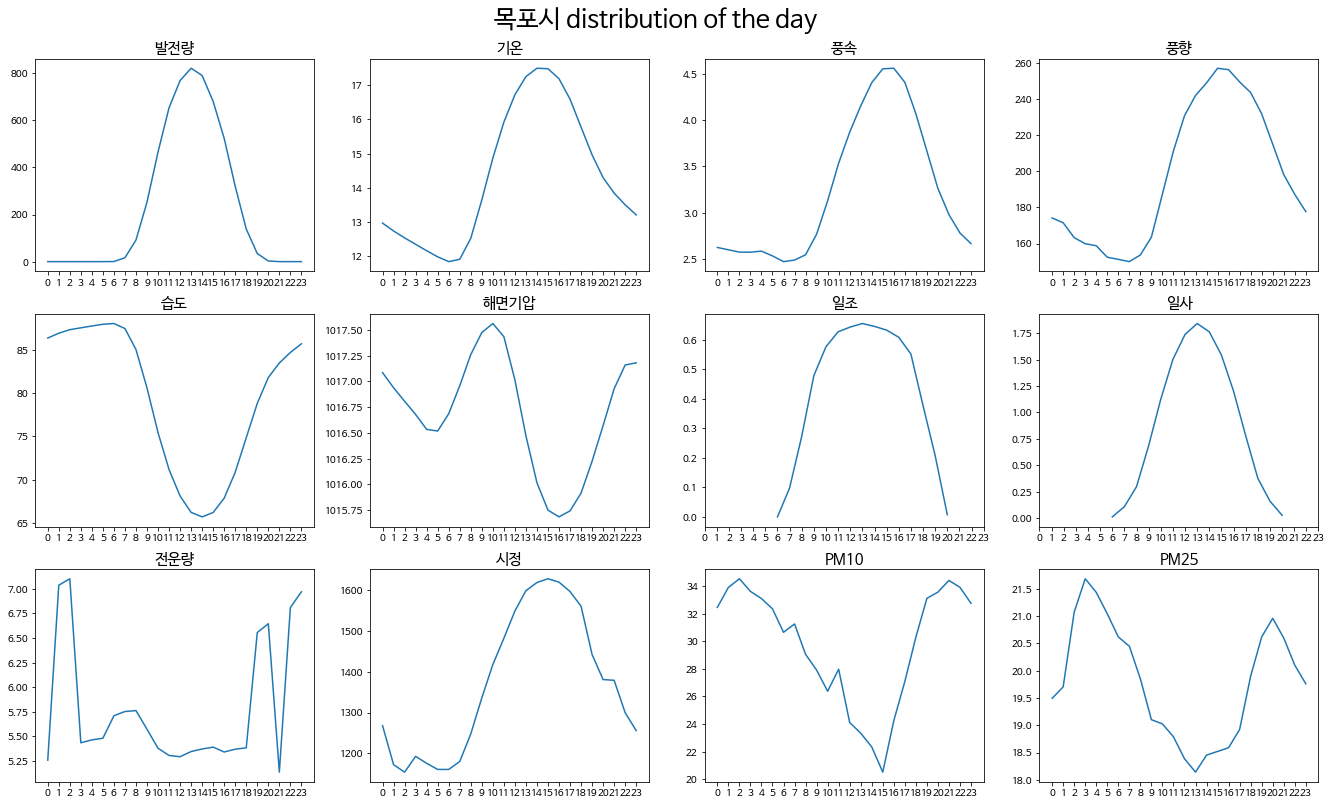

In [ ]:
day_plot(Mp_df, col_list, '목포시')

## deviation of the variable
태양광 외에 비슷한 주기성을 띄는 변수들의 주기성을 제거한 편차 열을 만들기

In [ ]:
def mean_data(df, col):  
  result_df = pd.DataFrame()
  for m in df['월'].unique():
    for h in range(0,24):
      h_df = df[(df['월'] == m) & (df['시간'] == h)]
      idx = h_df.index
      mean = h_df[col].mean()
      mean_df = pd.DataFrame([[m, h, mean]], columns=['월','시간', '평균'])
      result_df = pd.concat([result_df, mean_df]).reset_index(drop=True)
  return result_df

In [ ]:
solar_mean = mean_data(Jj_df, '발전량')
solar_mean.head()

,월,시간,평균
0,1,0,0.0
1,1,1,0.0
2,1,2,0.0
3,1,3,0.0
4,1,4,0.0


In [ ]:
def deviation(df, cols):
  data = df.copy()

  for i in cols:
    col = i
    mean_df =  mean_data(data, col)
    month = mean_df['월'].unique()
    hour = mean_df['시간'].unique()
  
    for m, h in [(x,y) for x in month for y in hour]:
      idx = data[(data['월'] == m) & (data['시간'] == h)].index
      mean_num = mean_df[(mean_df['월'] == m) & (mean_df['시간'] == h)]['평균']
      mean_num = np.float64(mean_num)
      for i in idx:
        data.loc[i,f'{col}편차'] = data.loc[i,f'{col}'] - mean_num
  return data

In [ ]:
Jj_df = deviation(Jj_df, [x for x in Jj_df.columns if x not in ['지역','일자','시간','월']])
Jj_df.head()

,지역,시간,발전량,일자,기온,풍속,풍향,습도,해면기압,일조,...,풍속편차,풍향편차,습도편차,해면기압편차,일조편차,일사편차,전운량편차,시정편차,PM10편차,PM25편차
0,경남 진주시,0,0.0,2017-01-01,-2.4,0.0,0.0,85.0,1030.4,NaN,...,-0.624194,-70.887097,19.201613,6.030645,NaN,NaN,NaN,-724.564516,38.322581,NaN
1,경남 진주시,1,0.0,2017-01-01,-3.0,0.1,0.0,86.0,1030.1,NaN,...,-0.543548,-68.629032,19.717742,5.855645,NaN,NaN,NaN,-723.096774,19.766129,NaN
2,경남 진주시,2,0.0,2017-01-01,-3.1,0.0,0.0,87.0,1030.5,NaN,...,-0.605645,-66.048387,18.411290,6.139516,NaN,NaN,NaN,-748.120968,17.169355,NaN
3,경남 진주시,3,0.0,2017-01-01,-3.5,0.1,0.0,88.0,1030.7,NaN,...,-0.456452,-62.338710,17.725806,6.296774,NaN,NaN,NaN,-745.653226,14.991935,NaN
4,경남 진주시,4,0.0,2017-01-01,-3.6,0.3,0.0,88.0,1030.1,NaN,...,-0.282258,-67.983871,16.959677,5.897581,NaN,NaN,NaN,-796.161290,15.588710,NaN


Text(0.5, 1.0, '태양광 편차')

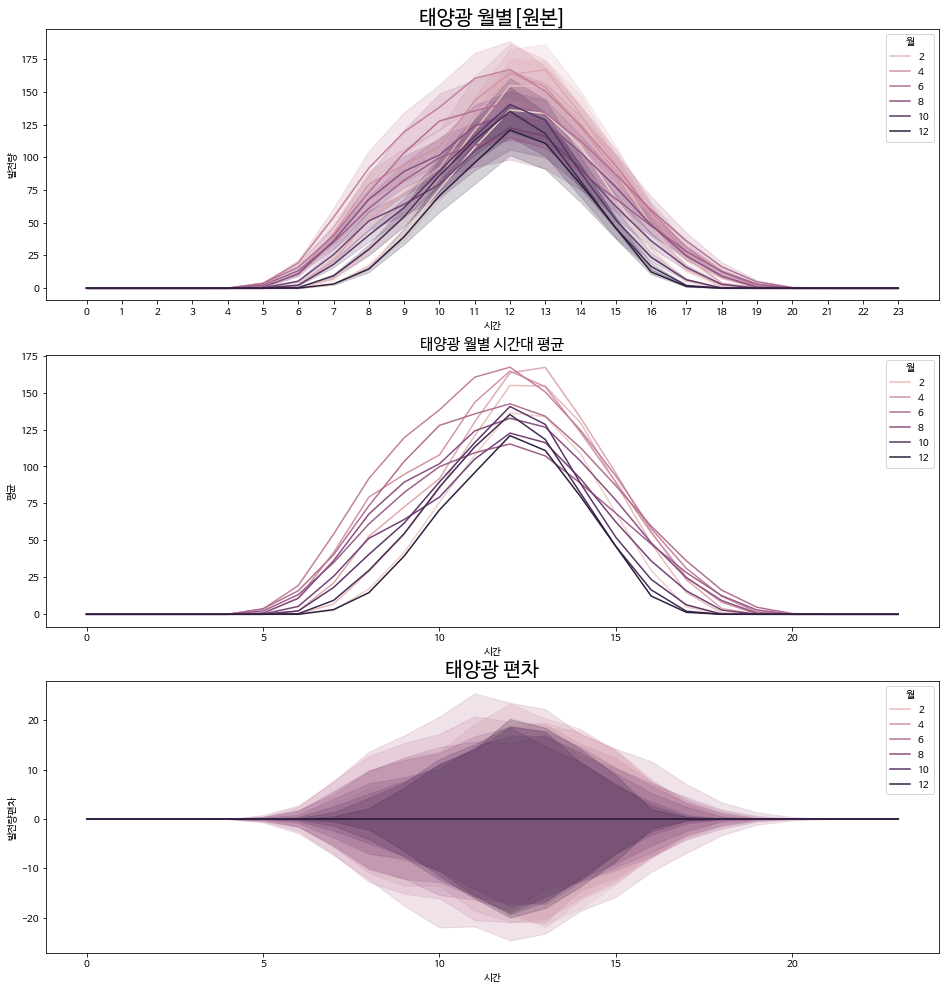

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16,17),nrows=3, ncols=1)

sns.lineplot(x='시간', y='발전량', hue='월', data=Jj_df, ax=ax1)
ax1.set_xticks(range(0,24))
ax1.set_xlabel('시간')
ax1.set_ylabel('발전량')
ax1.set_title('태양광 월별[원본]', fontsize=20)

sns.lineplot(x='시간', y='평균', hue='월', data=solar_mean, ax=ax2)
ax2.set_title('태양광 월별 시간대 평균', fontsize=15)

sns.lineplot(x='시간', y='발전량편차', hue='월', data=Jj_df, ax=ax3)
ax3.set_title('태양광 편차', fontsize=20)

In [ ]:
Gn_df = deviation(Gn_df, [x for x in Gn_df.columns if x not in ['지역','일자','시간','월']])
Gn_df.head()

,지역,시간,발전량,일자,기온,풍속,풍향,습도,해면기압,일조,...,풍속편차,풍향편차,습도편차,해면기압편차,일조편차,일사편차,전운량편차,시정편차,PM10편차,PM25편차
0,강원 강릉시,0,0.0,2017-01-01,4.3,4.1,290.0,45.0,1026.8,NaN,...,0.929839,37.580645,2.137097,4.411570,NaN,NaN,NaN,748.024194,20.217742,20.305556
1,강원 강릉시,1,0.0,2017-01-01,4.3,5.1,290.0,46.0,1027.2,NaN,...,1.934677,39.274194,3.032258,4.903279,NaN,NaN,NaN,744.443548,26.338710,25.961905
2,강원 강릉시,2,0.0,2017-01-01,4.4,4.4,290.0,44.0,1027.0,NaN,...,1.087097,40.161290,0.822581,4.620492,NaN,NaN,NaN,881.766129,26.983871,31.292453
3,강원 강릉시,3,0.0,2017-01-01,4.3,3.5,320.0,44.0,1027.1,NaN,...,0.119355,70.483871,0.588710,4.398347,NaN,NaN,NaN,1632.193548,26.814516,23.473214
4,강원 강릉시,4,0.0,2017-01-01,4.2,3.4,320.0,44.0,1026.8,NaN,...,0.040323,65.000000,0.604839,4.325620,NaN,NaN,NaN,698.419355,25.357724,24.387387


In [ ]:
Mp_df = deviation(Mp_df, [x for x in Mp_df.columns if x not in ['지역','일자','시간','월']])
Mp_df.head()

,지역,시간,발전량,일자,기온,풍속,풍향,습도,해면기압,일조,...,풍속편차,풍향편차,습도편차,해면기압편차,일조편차,일사편차,전운량편차,시정편차,PM10편차,PM25편차
0,전남 목포시,0,0.0,2013-01-01,-2.0,4.1,160.0,93.0,1021.4,NaN,...,0.768664,-16.650485,11.829384,-4.377778,NaN,NaN,-2.279621,676.064815,98.448598,NaN
1,전남 목포시,1,0.0,2013-01-01,-2.2,3.7,160.0,95.0,1021.3,NaN,...,0.423963,-16.538462,13.347619,-4.344240,NaN,NaN,NaN,NaN,5.466981,NaN
2,전남 목포시,2,0.0,2013-01-01,-2.4,3.6,160.0,95.0,1021.2,NaN,...,0.361751,-5.693780,13.201923,-4.457143,NaN,NaN,NaN,NaN,-0.735849,NaN
3,전남 목포시,3,0.0,2013-01-01,-2.7,3.6,160.0,95.0,1020.8,NaN,...,0.317512,-2.142857,13.119048,-4.926267,NaN,NaN,1.461905,503.792627,2.234742,NaN
4,전남 목포시,4,0.0,2013-01-01,-2.9,4.0,160.0,94.0,1020.0,NaN,...,0.680645,-13.875598,12.066038,-5.500922,NaN,NaN,1.189573,482.493088,3.462264,NaN


In [ ]:
data = pd.concat([Jj_df, Gn_df, Mp_df])
data

,지역,시간,발전량,일자,기온,풍속,풍향,습도,해면기압,일조,...,풍속편차,풍향편차,습도편차,해면기압편차,일조편차,일사편차,전운량편차,시정편차,PM10편차,PM25편차
0,경남 진주시,0,0.0,2017-01-01,-2.4,0.0,0.0,85.0,1030.4,NaN,...,-0.624194,-70.887097,19.201613,6.030645,NaN,NaN,NaN,-724.564516,38.322581,NaN
1,경남 진주시,1,0.0,2017-01-01,-3.0,0.1,0.0,86.0,1030.1,NaN,...,-0.543548,-68.629032,19.717742,5.855645,NaN,NaN,NaN,-723.096774,19.766129,NaN
2,경남 진주시,2,0.0,2017-01-01,-3.1,0.0,0.0,87.0,1030.5,NaN,...,-0.605645,-66.048387,18.411290,6.139516,NaN,NaN,NaN,-748.120968,17.169355,NaN
3,경남 진주시,3,0.0,2017-01-01,-3.5,0.1,0.0,88.0,1030.7,NaN,...,-0.456452,-62.338710,17.725806,6.296774,NaN,NaN,NaN,-745.653226,14.991935,NaN
4,경남 진주시,4,0.0,2017-01-01,-3.6,0.3,0.0,88.0,1030.1,NaN,...,-0.282258,-67.983871,16.959677,5.897581,NaN,NaN,NaN,-796.161290,15.588710,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61338,전남 목포시,19,0.0,2019-12-31,-2.0,8.2,360.0,61.0,1034.0,NaN,...,4.152995,163.857143,-14.556604,8.787097,NaN,NaN,-1.247191,561.812865,11.308411,-14.362069
61339,전남 목포시,20,0.0,2019-12-31,-2.8,4.6,20.0,65.0,1033.9,NaN,...,0.858065,-152.780488,-11.573460,8.488018,NaN,NaN,0.714286,543.587209,8.558685,-15.504348
61340,전남 목포시,21,0.0,2019-12-31,-2.8,3.3,20.0,65.0,1033.9,NaN,...,-0.226728,-143.875598,-11.734597,8.350691,NaN,NaN,3.638498,501.198157,3.255814,-13.196581
61341,전남 목포시,22,0.0,2019-12-31,-2.6,4.7,20.0,63.0,1033.5,NaN,...,1.305530,-153.160377,-14.450237,7.898618,NaN,NaN,2.164835,551.588235,-0.434579,-15.438596


# Save data


In [ ]:
data.to_csv('/content/gdrive/MyDrive/tmp_data/TestData.csv', index=None) #편차 열 생성 데이터